# Data Wrangling January 2020 #
## Lanie Preston & Floor Kouwenberg ##

Lanie Preston (VU Student Nr: 2629403)

Floor Kouwenberg (VU ID: 2618232)

In [1]:
#read in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup


## Data on USA Dairy Production per Year and Quarter ## 

In [2]:
us_dairy_production = pd.read_excel('annualmilkprodfactors.xlsx', index_col=0)
us_dairy_production = us_dairy_production.dropna(axis=0)
#us_dairy_production = us_dairy_production.reset_index
milk_production =  us_dairy_production[['Milk production']]
us_dairy_production

,Milk cows and heifers that have calved,"Replace-ment heifers, 500+ lbs.",Replace-ments per 100 cows,Average number of milk cows in the U.S.,Milk per cow,Milk production,Average price paid for milk 1,Dairy ration value 2,Milk-feed ratio 3,Price,Milk volume required to buy a cow,Alfalfa hay price received by farmers,Slaughter cow price 4
Year,,,,,,,,,,,,,
1980.0,10758.2,4158.5,38.654236,10799.0,11891.0,128406.0,13.0,4.837357,2.717149,1190.0,9153.846154,72.000000,45.730000
1981.0,10849.0,4341.6,40.018435,10898.0,12183.0,132770.0,13.8,5.035243,2.759031,1200.0,8695.652174,70.900000,41.930000
1982.0,10985.9,4546.7,41.386687,11011.0,12306.0,135505.0,13.6,4.422102,3.088127,1110.0,8161.764706,72.733333,39.960000
1983.0,11046.8,4544.8,41.141326,11059.0,12622.0,139588.0,13.6,5.235034,2.609620,1030.0,7573.529412,78.700000,39.350000
1984.0,11058.7,4532.7,40.987639,10793.0,12541.0,135351.0,13.5,5.338787,2.540000,895.0,6629.629630,79.483333,39.810000
1985.0,10776.9,4770.0,44.261337,10981.0,13024.0,143012.0,12.7,4.500458,2.840000,860.0,6771.653543,73.675000,38.310000
1986.0,11115.5,4708.7,42.361567,10773.0,13285.0,143124.0,12.5,3.774750,3.390000,820.0,6560.000000,64.641667,37.180000
1987.0,10466.4,4304.9,41.130666,10327.0,13819.0,142709.0,12.5,3.445415,3.640000,920.0,7360.000000,65.966667,44.800000
1988.0,10311.2,4122.3,39.978858,10224.0,14185.0,145034.0,12.2,4.721579,2.630000,990.0,8114.754098,82.508333,47.910000


## Data on Party Divisions per Year ##

In [28]:
#seats per party per year 
senate_division = pd.read_excel('senate_division.xlsx', index_col = "Years")
senate_division_per_year = pd.DataFrame(index=[], columns=senate_division.columns)

for index, row in senate_division.iterrows():
    row.name = int(index.split("–")[0])
    senate_division_per_year = senate_division_per_year.append(row)
    row.name = row.name+1
    senate_division_per_year = senate_division_per_year.append(row)
    
senate_division_per_year = senate_division_per_year.fillna(0)
senate_division_per_year

,Congress,Total,Democrats,Republicans,Others,Vacancies,HOR: Total,HOR: Democrats,HOR: Republicans,HOR: Other,HOR: Vacancies
1997,105.0,100.0,45.0,55.0,0.0,0.0,435.0,206.0,227.0,2.0,0.0
1998,105.0,100.0,45.0,55.0,0.0,0.0,435.0,206.0,227.0,2.0,0.0
1999,106.0,100.0,45.0,55.0,0.0,0.0,435.0,211.0,223.0,1.0,0.0
2000,106.0,100.0,45.0,55.0,0.0,0.0,435.0,211.0,223.0,1.0,0.0
2001,107.0,100.0,50.0,50.0,0.0,0.0,435.0,212.0,221.0,2.0,0.0
2002,107.0,100.0,50.0,50.0,0.0,0.0,435.0,212.0,221.0,2.0,0.0
2003,108.0,100.0,48.0,51.0,1.0,0.0,435.0,205.0,229.0,1.0,0.0
2004,108.0,100.0,48.0,51.0,1.0,0.0,435.0,205.0,229.0,1.0,0.0
2005,109.0,100.0,44.0,55.0,1.0,0.0,435.0,202.0,232.0,1.0,0.0
2006,109.0,100.0,44.0,55.0,1.0,0.0,435.0,202.0,232.0,1.0,0.0


## Data on Dollar Amounts of Subsudies paid to Dairy Farmers by the US Government ##

In [24]:
#government payouts by program
#read in separate excel files 
payouts2010 = pd.read_excel('GP_PaymentsUSA2010.xlsx')
payouts2000 = pd.read_excel('GP_PaymentsUSA2000.xlsx')
payouts1990 = pd.read_excel('GP_PaymentsUSA1990.xlsx')

#give all dfs sensible column names 
def clean_df(df):
    if 'Unnamed: 4' in list(df):
        del df['Unnamed: 4']
    df.rename(columns= {'Unnamed: 0': 'Program'}, inplace=True)
    df.rename(columns= {'United States': 'Program'}, inplace=True)
    return df

#clean all dataframes for merging 
payouts1990 = clean_df(payouts1990)
payouts2000 = clean_df(payouts2000)
payouts2010 = clean_df(payouts2010)
payouts2000[payouts2000.select_dtypes(include=['number']).columns] *= 1000


payouts_early = pd.merge(payouts1990, payouts2000, how='outer')
payouts_early = payouts_early.drop([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997], axis=1)
all_payouts = pd.merge(payouts_early, payouts2010, how='outer')
search_values = ['dairy','milk']
dairy_payouts = all_payouts[all_payouts['Program'].str.contains('|'.join(search_values),  na=False, case=False)]
dairy_payouts = dairy_payouts.set_index('Program')
dairy_payouts.columns = dairy_payouts.columns.map(int)

In [66]:
lobbies = pd.read_excel("AnnualLobyingOnDairy.xlsx", index_cols=0)
#reset index so years is a column
lobbies_final = lobbies.pivot_table(columns='Year')
all_funding = dairy_payouts.append(lobbies_final)
all_funding = all_funding.fillna(0)
all_funding

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Milk income loss payments,0.0,0.0,0.0,0.0,859642.0,913317.0,205677.0,9587.0,431231.0,73902.0,...,51660.0,-100.0,446572.0,231704.0,-129.0,-40.0,-64.0,-43.0,-20.0,0.0
Dairy Margin Coverage Program,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,686.0,10394.0,19.0,250013.0,214000.0
Lobbies to Democrats,707800.0,0.0,809200.0,0.0,918200.0,0.0,1000000.0,0.0,1100000.0,0.0,...,1600000.0,0.0,999000.0,0.0,791500.0,0.0,943400.0,0.0,821200.0,0.0
Lobbies to Republicans,1300000.0,0.0,2100000.0,0.0,2200000.0,0.0,2400000.0,0.0,2900000.0,0.0,...,2400000.0,0.0,3700000.0,0.0,2800000.0,0.0,3000000.0,0.0,2400000.0,0.0
Total Lobbies,2245000.0,3051110.0,2798900.0,3260000.0,4314700.0,4073436.0,4839800.0,4841312.0,3840045.0,5220448.0,...,5662885.0,6695032.0,7302248.0,8347149.0,6951794.0,7116441.0,6480567.0,6009870.0,7590843.0,5637167.0


## Plots

<function matplotlib.pyplot.show(*args, **kw)>

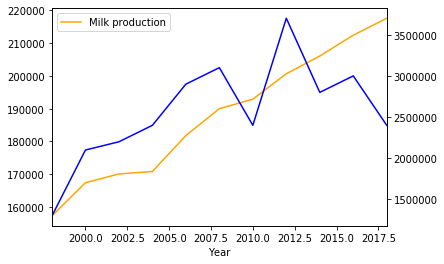

In [109]:
#Plot milk production and lobbies to Republicans on the same graph to see how they correlate 
all_funding
lobbies = all_funding.iloc[3]
lobbies_every_other = lobbies[::2]

sampled_production = milk_production[::2]
sampled_production = sampled_production.iloc[9:20]


ax3 = sampled_production.plot(color = 'orange', label="Production")
ax4 = lobbies_every_other.plot(secondary_y=True, color='blue', label="Payouts")

ax1.legend(loc=3)
ax2.legend(loc=4)
plt.show

In [136]:
#Plot milk production and Government Payouts to the Dairy Industry to see if they correlate 

#subsudies_repub = all_funding.iloc[1]
#subsudies_every_other = lobbies_repub[::2]
#short_subsudies_repub = subsudies_repub[17:22]
#to handle outlier 
#short_subsudies_repub[2017] = short_subsudies_repub.mean()

sampled_production = milk_production[::2]
sampled_production = sampled_production.iloc[9:20]
sampled_production.iloc[8:11]

KeyError: 2014

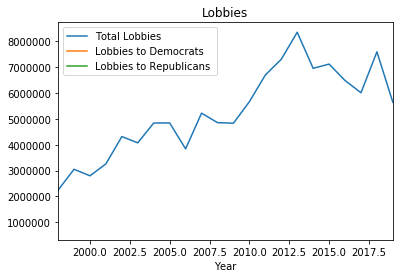

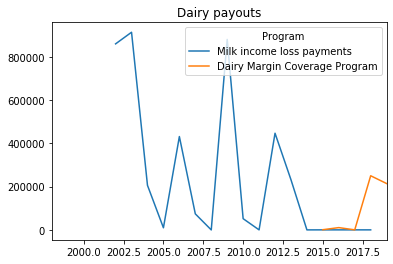

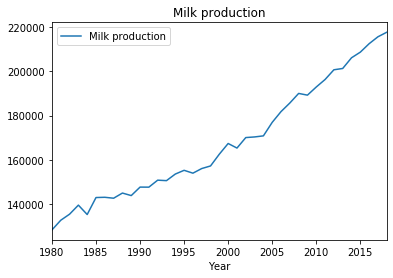

In [103]:
lobbies = pd.read_excel('AnnualLobyingOnDairy.xlsx', index_col=0)
lobbies.index =  pd.to_datetime(lobbies.index, format="%Y").year


lobbies.plot(title = "Lobbies")
dairy_payouts.T.plot(title = "Dairy payouts")
milk_production.plot(title = "Milk production")

In [ ]:
division = senate_division_per_year[["Democrats", "Republicans"]]
division['division'] = division['Republicans'] - division['Democrats']
division['division'].plot.bar()